## Datan lataus ja esikäsittely

Tässä osiossa luetaan Tilastokeskuksen PX-Webistä ladattu JSON-stat2-muotoinen aineisto, muunnetaan se Pandas DataFrameksi, uudelleennimetään sarakkeet ohjeen mukaisesti, muunnetaan aikaleimat ja tarkistetaan sekä poistetaan puuttuvat arvot.


1. Alkuperäisen DataFramen valmistelu

In [ ]:
import pandas as pd   # Tuodaan pandas-kirjasto, joka auttaa taulukoiden käsittelyssä
import json           # Tuodaan json-kirjasto, jolla voidaan lukea JSON-muotoista dataa

# Määritellään tiedoston polku
file_path = r"D:\GitHub\PythonDataAnalytics\doc\001_12ib_2025m04_20250601-182151.json"

# Avataan tiedosto ja luetaan sen sisältö Pythonin muotoon
with open(file_path, encoding="utf-8") as f:
    data = json.load(f)

# Poimitaan datasta varsinainen matkustajamäärätieto ja tiedot eri muuttujista
values = data['value']            # Lista kaikista datapisteistä
dimensions = data['dimension']    # Tiedot eri muuttujista, kuten lentoasema, kuukausi jne.
dim_names = list(dimensions.keys())   # Muuttujien nimet listana
dim_categories = [dimensions[k]['category']['label'] for k in dim_names]  # Jokaisen muuttujan mahdolliset arvot

import itertools
# Muodostetaan kaikki mahdolliset yhdistelmät muuttujista
index_tuples = list(itertools.product(*[list(c.values()) for c in dim_categories]))

# Luodaan Pandas DataFrame, joka sisältää kaikki muuttujien yhdistelmät taulukkona
df = pd.DataFrame(index_tuples, columns=dim_names)

# Lisätään DataFrameen matkustajamäärä-sarake
df['Passengers'] = values

# Tarkista sarakkeet
print(df.columns)

# Valitse vain matkustajamäärä-rivit testauksia varten.
df = df[df["Tiedot"] == "Matkustajamäärä"].copy()

Index(['Kuukausi', 'Ilmoittava lentoasema', 'Lennon tyyppi',
       'Saapuneet/lähteneet', 'Toinen lentoasema', 'Tiedot', 'Passengers'],
      dtype='object')


In [ ]:
# Valitaan vain rivit, joissa 'Tiedot' on 'Matkustajamäärä'
df_matkustajat = df[df["Tiedot"] == "Matkustajamäärä"].copy()

# Tulostetaan muutama esimerkkirivi alkuperäisestä datasta
df_matkustajat.head(10)

,Kuukausi,Ilmoittava lentoasema,Lennon tyyppi,Saapuneet/lähteneet,Toinen lentoasema,Tiedot,Passengers
0,2019M01,Yhteensä,Yhteensä,Saapuneet/lähteneet yhteensä,Yhteensä,Matkustajamäärä,1969169
4,2019M01,Yhteensä,Yhteensä,Saapuneet/lähteneet yhteensä,Helsinki-Vantaa,Matkustajamäärä,276932
8,2019M01,Yhteensä,Yhteensä,Saapuneet/lähteneet yhteensä,Muut kotimaan lentoasemat,Matkustajamäärä,279130
12,2019M01,Yhteensä,Yhteensä,Saapuneet/lähteneet yhteensä,Kansainvälinen,Matkustajamäärä,1413107
16,2019M01,Yhteensä,Yhteensä,Saapuneet,Yhteensä,Matkustajamäärä,984340
20,2019M01,Yhteensä,Yhteensä,Saapuneet,Helsinki-Vantaa,Matkustajamäärä,129975
24,2019M01,Yhteensä,Yhteensä,Saapuneet,Muut kotimaan lentoasemat,Matkustajamäärä,147386
28,2019M01,Yhteensä,Yhteensä,Saapuneet,Kansainvälinen,Matkustajamäärä,706979
32,2019M01,Yhteensä,Yhteensä,Lähteneet,Yhteensä,Matkustajamäärä,984829
36,2019M01,Yhteensä,Yhteensä,Lähteneet,Helsinki-Vantaa,Matkustajamäärä,146957


In [ ]:
# Nimetään sarakkeet selkeämmin
df_matkustajat = df_matkustajat.rename(columns={
    "Kuukausi": "MonthCode",
    "Ilmoittava lentoasema": "Airport"
})
# Otetaan mukaan vain oleelliset sarakkeet
df_matkustajat = df_matkustajat[["MonthCode", "Airport", "Passengers"]]

# Muunnetaan kuukausikoodi oikeaksi päivämääräksi
df_matkustajat["Month"] = pd.to_datetime(df_matkustajat["MonthCode"], format="%YM%m")

# Asetetaan päivämäärä indeksiksi
df_matkustajat = df_matkustajat.set_index("Month")

# Varmistetaan, että matkustajamäärä on numeerinen
df_matkustajat["Passengers"] = pd.to_numeric(df_matkustajat["Passengers"], errors="coerce")

# Poistetaan puuttuvat arvot
df_matkustajat = df_matkustajat.dropna(subset=["Passengers"])

# Järjestetään DataFrame ajan mukaan
df_matkustajat = df_matkustajat.sort_index()

# Katsotaan lopputulos
df_matkustajat.head(10)

,MonthCode,Airport,Passengers
Month,,,
2019-01-01,2019M01,Yhteensä,1969169
2019-01-01,2019M01,Yhteensä,276932
2019-01-01,2019M01,Yhteensä,279130
2019-01-01,2019M01,Yhteensä,1413107
2019-01-01,2019M01,Yhteensä,984340
2019-01-01,2019M01,Yhteensä,129975
2019-01-01,2019M01,Yhteensä,147386
2019-01-01,2019M01,Yhteensä,706979
2019-01-01,2019M01,Yhteensä,984829


In [31]:
# Määritellään isot lentoasemat omaksi listaksi
large_airports = ["Helsinki-Vantaa", "Oulu"]

# Lisätään uusi sarake, joka kertoo onko lentoasema "Large" vai "Small"
df_matkustajat["AirportGroup"] = df_matkustajat["Airport"].apply(
    lambda x: "Large" if x in large_airports else "Small"
)

# Näytetään esimerkkejä ryhmittelystä
df_matkustajat[["Airport", "AirportGroup"]].drop_duplicates().head(10)


,Airport,AirportGroup
Month,,
2019-01-01,Yhteensä,Small
2019-01-01,Helsinki-Vantaa,Large
2019-01-01,Enontekiö,Small
2019-01-01,Ivalo,Small
2019-01-01,Joensuu,Small
2019-01-01,Jyväskylä,Small
2019-01-01,Kajaani,Small
2019-01-01,Kemi-Tornio,Small
2019-01-01,Kittilä,Small


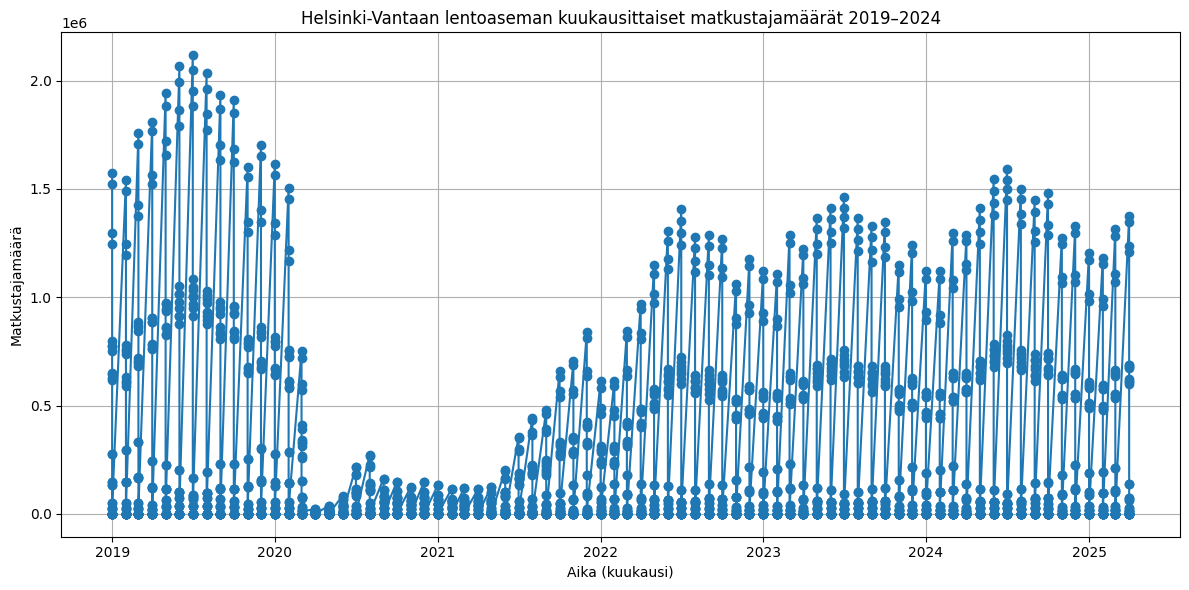

In [ ]:
import matplotlib.pyplot as plt

# Valitaan vain Helsinki-Vantaan tiedot
helsinki = df_matkustajat[df_matkustajat["Airport"] == "Helsinki-Vantaa"]

# Piirretään aikasarjakuvaaja matkustajamäärien kehityksestä
plt.figure(figsize=(12,6))
plt.plot(helsinki.index, helsinki["Passengers"], marker='o')
plt.title("Helsinki-Vantaan lentoaseman kuukausittaiset matkustajamäärät 2019–2024")
plt.xlabel("Aika (kuukausi)")
plt.ylabel("Matkustajamäärä")
plt.grid(True)
plt.tight_layout()
plt.show()

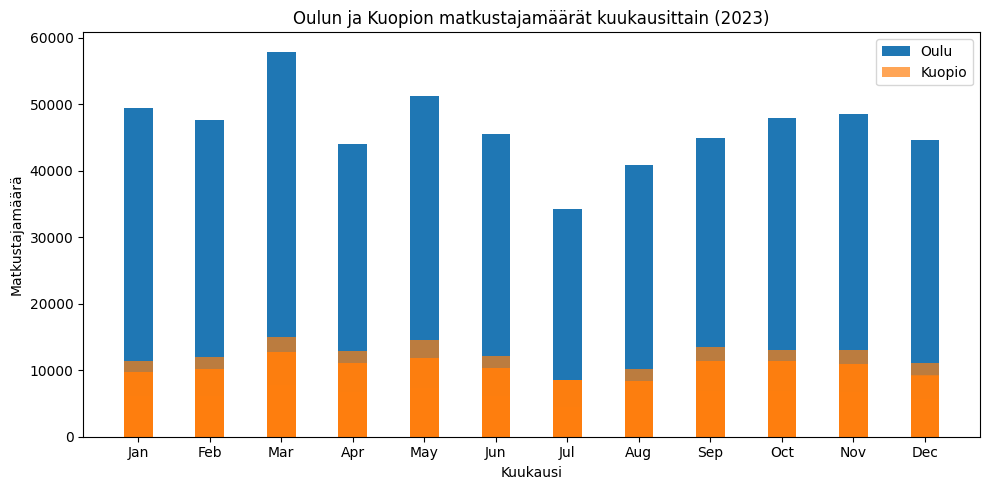

In [ ]:
import matplotlib.pyplot as plt
# Valitaan Oulun ja Kuopion vuoden 2023 tiedot
oulukuopio = df_matkustajat[
    ((df_matkustajat["Airport"] == "Oulu") | (df_matkustajat["Airport"] == "Kuopio"))
    & (df_matkustajat["MonthCode"].str.startswith("2023"))
]
# Erotellaan tiedot lentokentittäin
oulu = oulukuopio[oulukuopio["Airport"] == "Oulu"]["Passengers"]
kuopio = oulukuopio[oulukuopio["Airport"] == "Kuopio"]["Passengers"]
# Kuukaudet pylväiden x-akselille
kuukaudet = oulukuopio.index.strftime('%b')[oulukuopio["Airport"] == "Oulu"]
# Piirretään pylväsdiagrammi
plt.figure(figsize=(10,5))
plt.bar(kuukaudet, oulu, width=0.4, label="Oulu")
plt.bar(kuukaudet, kuopio, width=0.4, label="Kuopio", alpha=0.7)
plt.title("Oulun ja Kuopion matkustajamäärät kuukausittain (2023)")
plt.xlabel("Kuukausi")
plt.ylabel("Matkustajamäärä")
plt.legend()
plt.tight_layout()
plt.show()

Korrelaatiokerroin: 0.33


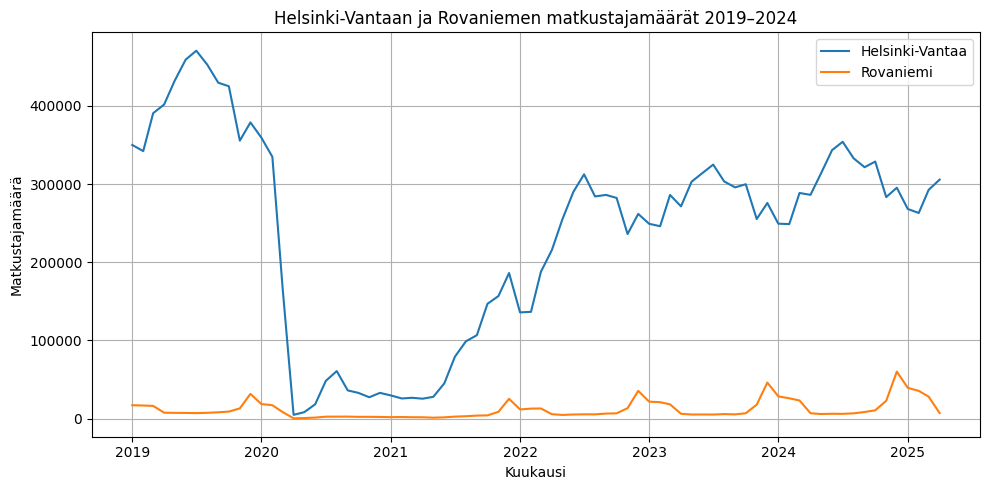

In [ ]:
# Poimitaan Helsinki-Vantaan ja Rovaniemen tiedot ja yhdistetään ne yhteen taulukkoon
df_corr = df_matkustajat[
    (df_matkustajat["Airport"] == "Helsinki-Vantaa") | (df_matkustajat["Airport"] == "Rovaniemi")
]
pivot_corr = df_corr.pivot_table(
    index=df_corr.index, columns="Airport", values="Passengers"
).dropna()

# Lasketaan Pearsonin korrelaatiokerroin
correlation = pivot_corr["Helsinki-Vantaa"].corr(pivot_corr["Rovaniemi"])
print(f"Korrelaatiokerroin: {correlation:.2f}")

# Piirretään viivakuvaajat rinnakkain
import matplotlib.pyplot as plt
plt.figure(figsize=(10,5))
plt.plot(pivot_corr.index, pivot_corr["Helsinki-Vantaa"], label="Helsinki-Vantaa")
plt.plot(pivot_corr.index, pivot_corr["Rovaniemi"], label="Rovaniemi")
plt.title("Helsinki-Vantaan ja Rovaniemen matkustajamäärät 2019–2024")
plt.xlabel("Kuukausi")
plt.ylabel("Matkustajamäärä")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [ ]:
# Otetaan vain Rovaniemi, joulukuu (Month = 12) ja vuodet 2019-2022
rovaniemi_joulu = df_matkustajat[
    (df_matkustajat["Airport"] == "Rovaniemi") &
    (df_matkustajat.index.month == 12) &
    (df_matkustajat.index.year >= 2019) & (df_matkustajat.index.year <= 2022)
]

# Poimitaan vuosi ja matkustajamäärä selkeästi taulukkoon
rovaniemi_joulu_table = rovaniemi_joulu.reset_index()[["Month", "Passengers"]]
rovaniemi_joulu_table["Year"] = rovaniemi_joulu_table["Month"].dt.year
rovaniemi_joulu_table = rovaniemi_joulu_table[["Year", "Passengers"]]
rovaniemi_joulu_table = rovaniemi_joulu_table.sort_values("Year")
rovaniemi_joulu_table


,Year,Passengers
0,2019,141843
1,2019,81150
2,2019,92
3,2019,60601
4,2019,72372
...,...,...
139,2022,23949
140,2022,22738
141,2022,14
142,2022,0


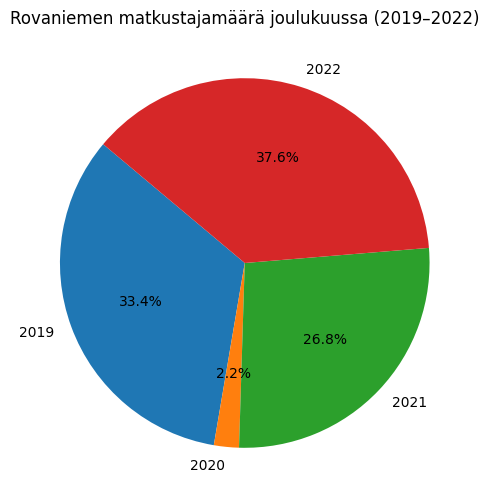

In [ ]:

# Summataan kaikki joulukuun matkustajamäärät yhteen per vuosi
rovaniemi_joulu_vuodet = rovaniemi_joulu_table.groupby("Year")["Passengers"].sum().reset_index()

years = rovaniemi_joulu_vuodet["Year"].astype(str)
passengers = rovaniemi_joulu_vuodet["Passengers"]

plt.figure(figsize=(6,6))
plt.pie(passengers, labels=years, autopct='%1.1f%%', startangle=140)
plt.title("Rovaniemen matkustajamäärä joulukuussa (2019–2022)")
plt.show()


In [48]:
# Otetaan mukaan vain vuoden 2023 tiedot analyysia varten
df_2023 = df_matkustajat[df_matkustajat.index.year == 2023].copy()

# Erotellaan suuret (Large) ja pienet (Small) lentoasemat
large_2023 = df_2023[df_2023["AirportGroup"] == "Large"]["Passengers"]
small_2023 = df_2023[df_2023["AirportGroup"] == "Small"]["Passengers"]

# Tulostetaan esimerkkirivit kummastakin ryhmästä
print("Suuret lentoasemat (esim. Helsinki-Vantaa, Oulu):")
print(large_2023.head())
print("\nPienet lentoasemat (esim. Kuopio, Rovaniemi):")
print(small_2023.head())


Suuret lentoasemat (esim. Helsinki-Vantaa, Oulu):
Month
2023-01-01    1121174
2023-01-01          0
2023-01-01     193320
2023-01-01     927854
2023-01-01     564670
Name: Passengers, dtype: int64

Pienet lentoasemat (esim. Kuopio, Rovaniemi):
Month
2023-01-01    1459126
2023-01-01     193272
2023-01-01     194431
2023-01-01    1071423
2023-01-01     726380
Name: Passengers, dtype: int64


In [49]:
from scipy.stats import levene

# Tehdään Levene-testi suurten ja pienten kenttien matkustajamäärien variansseille
stat_levene, p_levene = levene(large_2023, small_2023)

print(f"Levene-testin testisuure: {stat_levene:.2f}")
print(f"Levene-testin p-arvo: {p_levene:.3f}")


Levene-testin testisuure: 529.26
Levene-testin p-arvo: 0.000


In [50]:
from scipy.stats import mannwhitneyu

# Suoritetaan Mann–Whitney U -testi
stat_mw, p_mw = mannwhitneyu(large_2023, small_2023, alternative="two-sided")

print(f"Mann–Whitney U -testin testisuure: {stat_mw:.2f}")
print(f"Mann–Whitney U -testin p-arvo: {p_mw:.3f}")


Mann–Whitney U -testin testisuure: 4747638.00
Mann–Whitney U -testin p-arvo: 0.000
